# 3. Модель 

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import random
import itertools

from matplotlib import pyplot as plt

from tqdm import tqdm

from pandarallel import pandarallel

import pymorphy2
import nltk
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from keras.preprocessing.sequence import pad_sequences

SEED = 1
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed(SEED)
    
pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Загрузка данных

In [2]:
abbr = pd.read_csv("../data/abbr.csv")
lenta_train = pd.read_csv("../data/lenta_train.csv")
lenta_test = pd.read_csv("../data/lenta_test.csv")

In [3]:
id2desc = {}
id2abbr = {}
for abbr, abbr_id, desc in abbr[["abbr_norm", "abbr_id", "desc_norm"]].values:
    id2desc[abbr_id] = desc
    id2abbr[abbr_id] = abbr

In [4]:
lenta_train["labels_new"] = (
    lenta_train["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
train_texts = list(map(lambda x: x.split(" "), lenta_train["text_new"].to_list()))
train_labels = list(map(lambda x: x.split(" "), lenta_train["labels_new"].to_list()))

lenta_test["labels_new"] = (
    lenta_test["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
test_texts = list(map(lambda x: x.split(" "), lenta_test["text_new"].to_list()))
test_labels = list(map(lambda x: x.split(" "), lenta_test["labels_new"].to_list()))

## 2. Сборка датасета

In [5]:
PAD_TOKEN = "<PAD>"
PAD_TOKEN_ID = 0

PAD_LABEL = "<NOLABEL>"
PAD_LABEL_ID = 0

EMPTY_LABEL = "_"
EMPTY_LABEL_ID = 1

train_texts_global = list(itertools.chain(*train_texts))
train_labels_global = list(itertools.chain(*train_labels))
train_labels_global = list(filter(lambda x: x != EMPTY_LABEL, train_labels_global))

UNIQUE_TOKENS = [PAD_TOKEN] + list(set(train_texts_global))
UNIQUE_LABELS = [PAD_LABEL, EMPTY_LABEL] + list(set(train_labels_global))

token2id = {label: i for i, label in enumerate(UNIQUE_TOKENS)}
id2token = {i: label for label, i in token2id.items()}

label2id = {label: i for i, label in enumerate(UNIQUE_LABELS)}
id2label = {i: label for label, i in label2id.items()}

MAX_SENTENCE_LEN = lenta_train.text_new.str.split(" ").str.len().max()
train_size = len(train_texts)
test_size = len(test_texts)
TOKENS_NUM = len(UNIQUE_TOKENS)
LABELS_NUM = len(UNIQUE_LABELS)

print(train_size, test_size, TOKENS_NUM, LABELS_NUM)

548700 137175 588317 5611


In [6]:
def get_tensor_dataset(sentences, labels, token2id, label2id, max_sent_len):
    sent_num = len(sentences)
    
    inputs = torch.zeros((sent_num, max_sent_len), dtype=torch.long)
    targets = torch.zeros((sent_num, max_sent_len), dtype=torch.long)
    
    for text_i, text in tqdm(enumerate(sentences)):
        text = text[:max_sent_len]
        for token_i, token in enumerate(text):
            label = labels[text_i][token_i]
            inputs[text_i, token_i] = token2id.get(token, 0)
            targets[text_i, token_i] = label2id.get(label, 0)
            
    return TensorDataset(inputs, targets)

train_dataset = get_tensor_dataset(sentences=train_texts, 
                                   labels=train_labels, 
                                   token2id=token2id, 
                                   label2id=label2id, 
                                   max_sent_len=MAX_SENTENCE_LEN)

test_dataset = get_tensor_dataset(sentences=test_texts, 
                                   labels=test_labels, 
                                   token2id=token2id, 
                                   label2id=label2id, 
                                   max_sent_len=MAX_SENTENCE_LEN)

548700it [05:34, 1640.85it/s]
137175it [01:25, 1613.07it/s]


In [6]:
# torch.save(train_dataset, "../data/train_dataset.tensor_dataset")
# torch.save(test_dataset, "../data/test_dataset.tensor_dataset")

train_dataset = torch.load("../data/train_dataset.tensor_dataset")
test_dataset = torch.load("../data/test_dataset.tensor_dataset")

## 3. Архитектура

In [7]:
class StackedConv1d(nn.Module):
    def __init__(self, features_num, layers_n=1, kernel_size=3, dropout=0.0):
        super().__init__()
        layers = []
        for _ in range(layers_n):
            conv_block = nn.Sequential(
                nn.Conv1d(
                    features_num, 
                    features_num, 
                    kernel_size, 
                    padding=kernel_size//2 
                ),
                nn.Dropout(dropout),
                nn.LeakyReLU()
            )
            layers.append(conv_block)
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        """x - BatchSize x FeaturesNum x SequenceLen"""
        for layer in self.layers:
            x = x + layer(x) 
        return x

class ConvAbbrTagger(nn.Module): 
    def __init__(self, tokens_num, labels_num, embedding_size=64, **kwargs):
        super().__init__()
        self.embeddings = nn.Embedding(tokens_num, embedding_size, padding_idx=0)
        
        self.backbone = StackedConv1d(embedding_size, **kwargs)
        
        self.out = nn.Linear(embedding_size, labels_num)
        self.labels_num = labels_num
    
    def forward(self, tokens):
        """tokens - BatchSize x MaxSentenceLen x MaxTokenLen"""
        batch_size, max_sent_len = tokens.shape

        embeddings = self.embeddings(tokens)  # BatchSize x MaxSentenceLen x EmbSize
        embeddings = embeddings.permute(0, 2, 1)  # BatchSize x EmbSize x MaxTokenLen
        
        features = self.backbone(embeddings) # BatchSize x EmbSize x MaxTokenLen
        logits = self.out(features.permute(0, 2, 1))
        
        return logits.permute(0, 2, 1)

In [8]:
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True,
                              num_workers=0)

test_dataloader = DataLoader(test_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False,
                              num_workers=0)

model         = ConvAbbrTagger(TOKENS_NUM, LABELS_NUM, 
                               embedding_size=64, 
                               layers_n=3,
                               kernel_size=5,
                               dropout=0.2)
loss_function = F.cross_entropy 
optimizer     = optim.Adam(model.parameters(), lr=1e-2)

In [9]:
for t in model.parameters():
    print(t.shape)

print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

torch.Size([588317, 64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([5611, 64])
torch.Size([5611])
Количество параметров 38078635


## 4. Обучение 

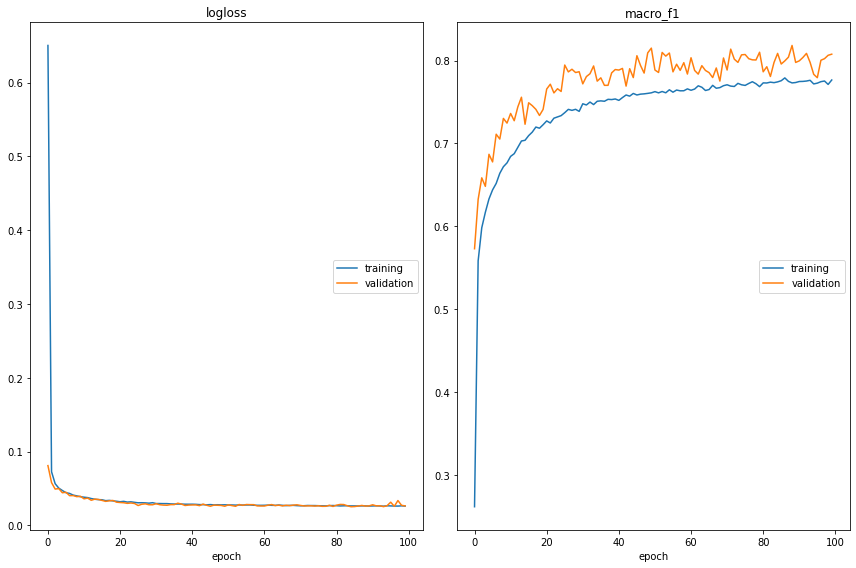

logloss
	training         	 (min:    0.026, max:    0.650, cur:    0.026)
	validation       	 (min:    0.025, max:    0.081, cur:    0.026)
macro_f1
	training         	 (min:    0.261, max:    0.779, cur:    0.777)
	validation       	 (min:    0.573, max:    0.818, cur:    0.808)


In [10]:
from livelossplot import PlotLosses

def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

def get_f1_score(batch_y, pred):
    pred_argmax = pred.argmax(1).cpu().detach().numpy().reshape(-1)
    batch_y = batch_y.cpu().detach().numpy().reshape(-1)
    return f1_score(batch_y, pred_argmax, average="macro")
    
liveplot = PlotLosses(groups={"logloss": ["train_logloss", "val_logloss"], 
                              "macro_f1": ["train_f1", "val_f1"]})
epoch_n = 100
steps_per_epoch = 100

device = torch.device("cuda")
model.to(device)

for epoch_i in range(epoch_n):
    model.train()
    loss_sum = 0
    f1_sum = 0
    batch_n = 0
    for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
        if batch_i > steps_per_epoch:
            break
            
        batch_x = copy_data_to_device(batch_x, device)
        batch_y = copy_data_to_device(batch_y, device)        

        pred = model(batch_x)
        loss = loss_function(pred, batch_y)
        
        model.zero_grad() 
        loss.backward() 
        optimizer.step()
        
        loss_sum += float(loss)
        f1_sum += float(get_f1_score(batch_y, pred))
        batch_n += 1

    model.eval()
    val_loss_sum = 0
    val_f1_sum = 0
    val_batch_n = 0
    with torch.no_grad():
        for batch_i, (batch_x, batch_y) in enumerate(test_dataloader):
            if batch_i > test_size // BATCH_SIZE:
                break
        batch_x = copy_data_to_device(batch_x, device)
        batch_y = copy_data_to_device(batch_y, device)        

        pred = model(batch_x)
        loss = loss_function(pred, batch_y)
        
        val_loss_sum += float(loss)
        val_f1_sum += float(get_f1_score(batch_y, pred))
        val_batch_n += 1
    
    liveplot.update({'train_logloss': loss_sum / batch_n, 
                     'val_logloss': val_loss_sum / val_batch_n,
                     'train_f1': f1_sum / batch_n,
                     'val_f1': val_f1_sum / val_batch_n})
    liveplot.draw()

## 5. Оценка качества 

In [ ]:
from tqdm import tqdm

model.eval()

results_by_batch = []
labels = []
with torch.no_grad():
    for batch_x, batch_y in tqdm(test_dataloader, 
                                      total=len(test_dataset)/BATCH_SIZE):
        batch_x = copy_data_to_device(batch_x, device)

        
        labels.append(batch_y.numpy())

        batch_pred = model(batch_x)
        results_by_batch.append(batch_pred.detach().cpu().numpy())


pred = np.concatenate(results_by_batch, axis=0)

  2%|▏         | 22/1071.6796875 [00:05<07:05,  2.47it/s]

In [ ]:


train_pred = predict_with_model(single_token_model, train_dataset)
train_loss = F.cross_entropy(torch.tensor(train_pred),
                             torch.tensor(train_labels))
print('Среднее значение функции потерь на обучении', float(train_loss))
print(classification_report(train_labels.view(-1), train_pred.argmax(1).reshape(-1), target_names=UNIQUE_TAGS))
print()

test_pred = predict_with_model(single_token_model, test_dataset)
test_loss = F.cross_entropy(torch.tensor(test_pred),
                            torch.tensor(test_labels))
print('Среднее значение функции потерь на валидации', float(test_loss))
print(classification_report(test_labels.view(-1), test_pred.argmax(1).reshape(-1), target_names=UNIQUE_TAGS))

In [149]:
pred_argmax = pred = model(batch_x).argmax(1).cpu().detach().numpy().reshape(-1)
batch_y = batch_y.cpu().detach().numpy().reshape(-1)
batch_x = batch_x.cpu().detach().numpy().reshape(-1)

ValueError: not enough values to unpack (expected 2, got 1)

In [128]:
x, y = test_dataset[0]
pred = model(torch.from_numpy(np.array([[t.numpy() for t in x]])).to(device))

pred = pred.argmax(1).cpu().detach().numpy().reshape(-1)
y = y.cpu().detach().numpy().reshape(-1)
x = x.cpu().detach().numpy().reshape(-1)

In [136]:
text = []
true_labels = []
pred_labels = []
for token, y_label, pred_label in zip(x, y, pred):
    if y_label != 0:
        text.append(id2token[token])
        true_labels.append(id2label[y_label])
        pred_labels.append(id2label[pred_label])